# Исследование влияния архитектурных изменений сверточной нейронной сети на качество распознавания на примере набора CIFAR-10

**Проведите ряд экспериментов с архитектурой нейронной сети:**

1. Исследуйте влияние количества слоев `Conv2D`.
2. Исследуйте влияние количества нейронов.
3. Исследуйте влияние `MaxPooling2D` в сети.
4. Исследуйте влияние `Dropout`.
5. Напишите выводы по результатам проведенных тестов.

In [1]:
import logging
import os
from pathlib import Path
import sys
from typing import Callable, Generator, List, Optional, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.callbacks import Callback, History
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam

from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Создать датафрейм для хранения результатов тестирования.

In [4]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['train', 'validation', 'test']
)

Определить вспомогательную функцию для визуализации процесса обучения.

In [5]:
def plot_history(
    history: History, 
    title: str, 
    axes: Optional[np.ndarray] = None
) -> None:
    if axes is None or not axes.all():
        _, axes = plt.subplots(1, 2, figsize=(12, 5))
        show_plot = True
    else:
        show_plot = False

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='train set'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='validation set'
    )
    axes[0].set_title(f"{title} (изменение loss)")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_xticks(history.epoch)
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='train set'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='validation set'
    )
    axes[1].set_title(f"{title} (изменение accuracy)")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_xticks(history.epoch)
    axes[1].grid(True)
    axes[1].legend()

    if show_plot:
        plt.show()

Задать путь для сохранения моделей нейронных сетей.

In [6]:
path = Path.home() / 'aiu-03-cifar-10-pro-models'
if not path.exists():
    Path.mkdir(path, parents=True)

## Подготовка данных

Загрузка данных CIFAR-10:

In [7]:
(x_org, y_org), (x_test_org, y_test_org) = cifar10.load_data()

In [8]:
print(f"{x_org.shape}, {x_test_org.shape}")

(50000, 32, 32, 3), (10000, 32, 32, 3)


Задать наименования меток CIFAR-10:

In [9]:
names = [
    "Самолет",  # airplane : 0
    "Автомобиль",  # automobile : 1
    "Птица",  # bird : 2
    "Кошка",  # cat : 3
    "Олень",  # deer : 4
    "Собака",  # dog : 5
    "Лягушка",  # frog : 6
    "Лошадь",  # horse : 7
    "Корабль",  # ship : 8
    "Грузовик",  # truck : 9
]

Отобразить примеры цифр из набора

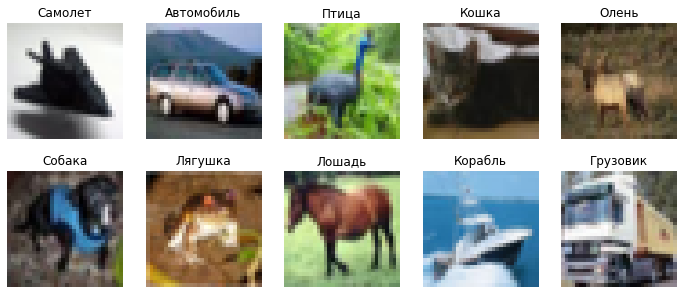

In [10]:
labels = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for label, ax in zip(labels, axes):
    ax.imshow(
        Image.fromarray(x_org[(y_org == label).flatten()][0]).convert('RGB')
    )

    ax.set_title(names[label])
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [11]:
x = x_org.copy() / 255
x_test = x_test_org.copy() / 255

In [12]:
print(f"{x.shape}, {x_test.shape}")

(50000, 32, 32, 3), (10000, 32, 32, 3)


Преобразовать ответы в унитарный код (one-hot)

In [13]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [14]:
print(f"{y.shape}, {y_test.shape}")

(50000, 10), (10000, 10)


Выделить обучающую и валидационную выборки.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=5000)

In [16]:
print(f"{x_train.shape}, {x_val.shape}")

(45000, 32, 32, 3), (5000, 32, 32, 3)


## Создание и обучение эталонной модели сверточной нейронной сети

Вспомогательный класс для предотвращения обучения в случае, если величина accuracy в течение нескольких эпох не превышает заданного порога.

In [17]:
class EarlyStoppingAtLowerAccuracy(Callback):

    def __init__(
        self, 
        patience: int = 0, 
        threshold: float = 0.15
    ):
        super(EarlyStoppingAtLowerAccuracy, self).__init__()

        self._patience = patience
        self._threshold = threshold

    def on_train_begin(self, logs=None):
        # Количество эпох, за время которых accuracy не увеличивается.
        self._wait = 0

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy < self._threshold:
            self._wait += 1
        else:
            self._wait = 0

        if self._wait > self._patience:
            self.model.stop_training = True

Вспомогательный класс для создания нейронной сети заданной архитектуры. Источник: [CIFAR-10 Image Classification in TensorFlow](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c).

In [18]:
def make_cifar10_architector(max_depth: int) -> Callable[[], Generator[int, None, None]]:
    def generate():
        for depth in range(max_depth):
            yield 0x20 << (depth >> 1)
            
    return generate

In [19]:
class Cifar10Net(Sequential):

    # Задать количество эпох для обучения.
    EPOCHS = 20

    def __init__(
        self,
        achitector: Callable[[], Generator[int, None, None]],
        dropout_rate: float = 0.25,
        use_pooling: bool = True,
        *args,
        **kwargs
    ):
        super(Cifar10Net, self).__init__(*args, **kwargs)

        self._conv_generator = achitector()
        self._dropout_rate = dropout_rate
        self._use_pooling = use_pooling

        self._build()

    def _build(self):
        for depth, neurons_number in enumerate(self._conv_generator, 1):
            if neurons_number <= 0:
                raise RuntimeError(
                    f"Illegal neurons number {neurons_number} on the depth {depth}"
                )

            if depth == 1:
                self.add(BatchNormalization(input_shape=(32, 32, 3)))

                self.add(
                    Conv2D(
                        neurons_number,
                        (3, 3),
                        padding='same',
                        input_shape=(32, 32, 3),
                        activation='relu'
                    )
                )
            else:
                if depth & 1:
                    self.add(BatchNormalization())

                self.add(
                    Conv2D(
                        neurons_number, 
                        (3, 3), 
                        padding='same',
                        activation='relu'
                    )
                )

                if not depth & 1:
                    if self._use_pooling:
                        self.add(MaxPooling2D(pool_size=(2, 2)))
                    if self._dropout_rate > 0.0:
                        self.add(Dropout(self._dropout_rate))

        if self._dropout_rate > 0.0 and depth & 1:
            self.add(Dropout(self._dropout_rate))

        self.add(Flatten())

        self.add(Dense(512, activation='relu'))
        if self._dropout_rate > 0.0:
            self.add(Dropout(self._dropout_rate))

        self.add(Dense(10, activation='softmax'))

    @classmethod
    def make_and_fit(
        cls,
        achitector: Callable[[], Generator[int, None, None]],
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: np.ndarray,
        y_val: np.ndarray,
        dropout_rate: float = 0.25,
        use_pooling: bool = True,
        batch_size: int = 128,
        threshold: float = 0.15,
        **kwargs
    ) -> Tuple[Sequential, History]:
        kwargs['validation_data'] = (x_val, y_val)
        if 'epochs' not in kwargs:
            kwargs['epochs'] = cls.EPOCHS

        verbose = kwargs.get('verbose', 0)
        kwargs['verbose'] = verbose

        
        net = cls(achitector, dropout_rate, use_pooling)

        callback = EarlyStoppingAtLowerAccuracy(
            patience=3,
            threshold=threshold
        )
        callbacks = kwargs.get('callbacks')
        if callbacks and isinstance(callbacks, list):
            callbacks.append(callback)
        else:
            callbacks = [callback]
        kwargs['callbacks'] = callbacks
        
        iteration = 1
        while True:
            if verbose:
                print(f"\n\nIteration #{iteration}\n")

            net.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy']
            )

            weights = net.get_weights()

            history = net.fit(
                x_train,
                y_train,
                **kwargs
            )

            if history.history['val_accuracy'][-1] > threshold:
                return net, history

            tf.keras.backend.clear_session()
            net = cls(achitector, dropout_rate, use_pooling)

            iteration += 1

Создать и обучить эталонную модель нейронной сети.

In [20]:
reference_net, history = Cifar10Net.make_and_fit(
    make_cifar10_architector(9), 
    x_train,
    y_train,
    x_val,
    y_val,
    batch_size=128,
    verbose=1
)



Iteration #1

Epoch 1/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5009 - accuracy: 0.4584 - val_loss: 1.1954 - val_accuracy: 0.5764
Epoch 2/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.0924 - accuracy: 0.6232 - val_loss: 0.9243 - val_accuracy: 0.6838
Epoch 3/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.9172 - accuracy: 0.6869 - val_loss: 0.8609 - val_accuracy: 0.7164
Epoch 4/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.8157 - accuracy: 0.7249 - val_loss: 0.7376 - val_accuracy: 0.7486
Epoch 5/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.7493 - accuracy: 0.7501 - val_loss: 0.7305 - val_accuracy: 0.7610
Epoch 6/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.6889 - accuracy: 0.7709 - val_loss: 0.7000 - val_accuracy: 0.7660
Epoch 7/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.6410 - accuracy: 0.7857 - val_loss:

Отобразить информацию о созданной нейронной сети.

In [21]:
print(reference_net.summary())

Model: "cifar10_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        

Отобразить прогресс обучения нейронной сети.

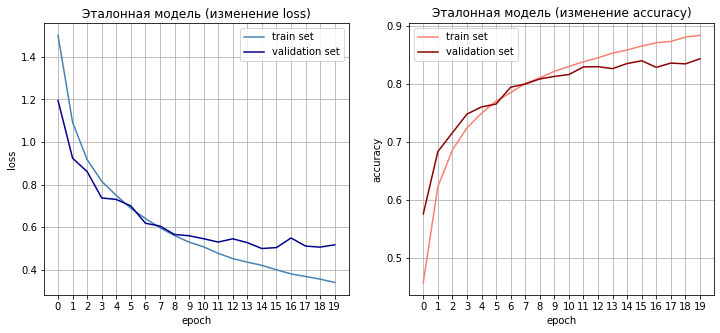

In [22]:
plot_history(history, title="Эталонная модель");

Сохранить архитектуру нейронной сети.

In [23]:
reference_net.save(path / 'aiu-03-cifar-10-pro-model-reference')

Получить значения loss и accuracy для тестовой выборки.

In [24]:
score = reference_net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.51858
Test accuracy: 0.84280


Распознать какое-либо изображение из тестового набора.

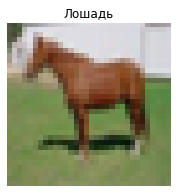


Предсказанная метка класса: Лошадь


In [25]:
idx = np.random.randint(0, x_test.shape[0])

_, ax = plt.subplots(figsize=(3, 3))

ax.imshow(
    Image.fromarray(x_test_org[idx]).convert('RGB')
)

ax.set_title(names[y_test_org[idx][0]])
ax.set_axis_off()

plt.show();

y_pred = np.argmax(reference_net.predict(x_test[idx][np.newaxis, :, :, :]))
print(f"\nПредсказанная метка класса: {names[y_pred]}")

Записать результаты в отчет.

In [26]:
def update_report(
    report: pd.DataFrame,
    category: str,
    value: str,
    history: History,
    score: List[int]
) -> None:
    report.loc[(category, value), :] = [
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1]
    ]

In [27]:
update_report(report, "Эталонная модель", "9", history, score)

## Исследование влияния количества сверточных слоев

Будем последовательно добавлять сверточные слои к нейронной сети с эталонной архитектурой для определения влияния количества серточных слоев на качество распознавания.

Done: 100%|██████████| 8/8 [15:04<00:00, 113.09s/it]


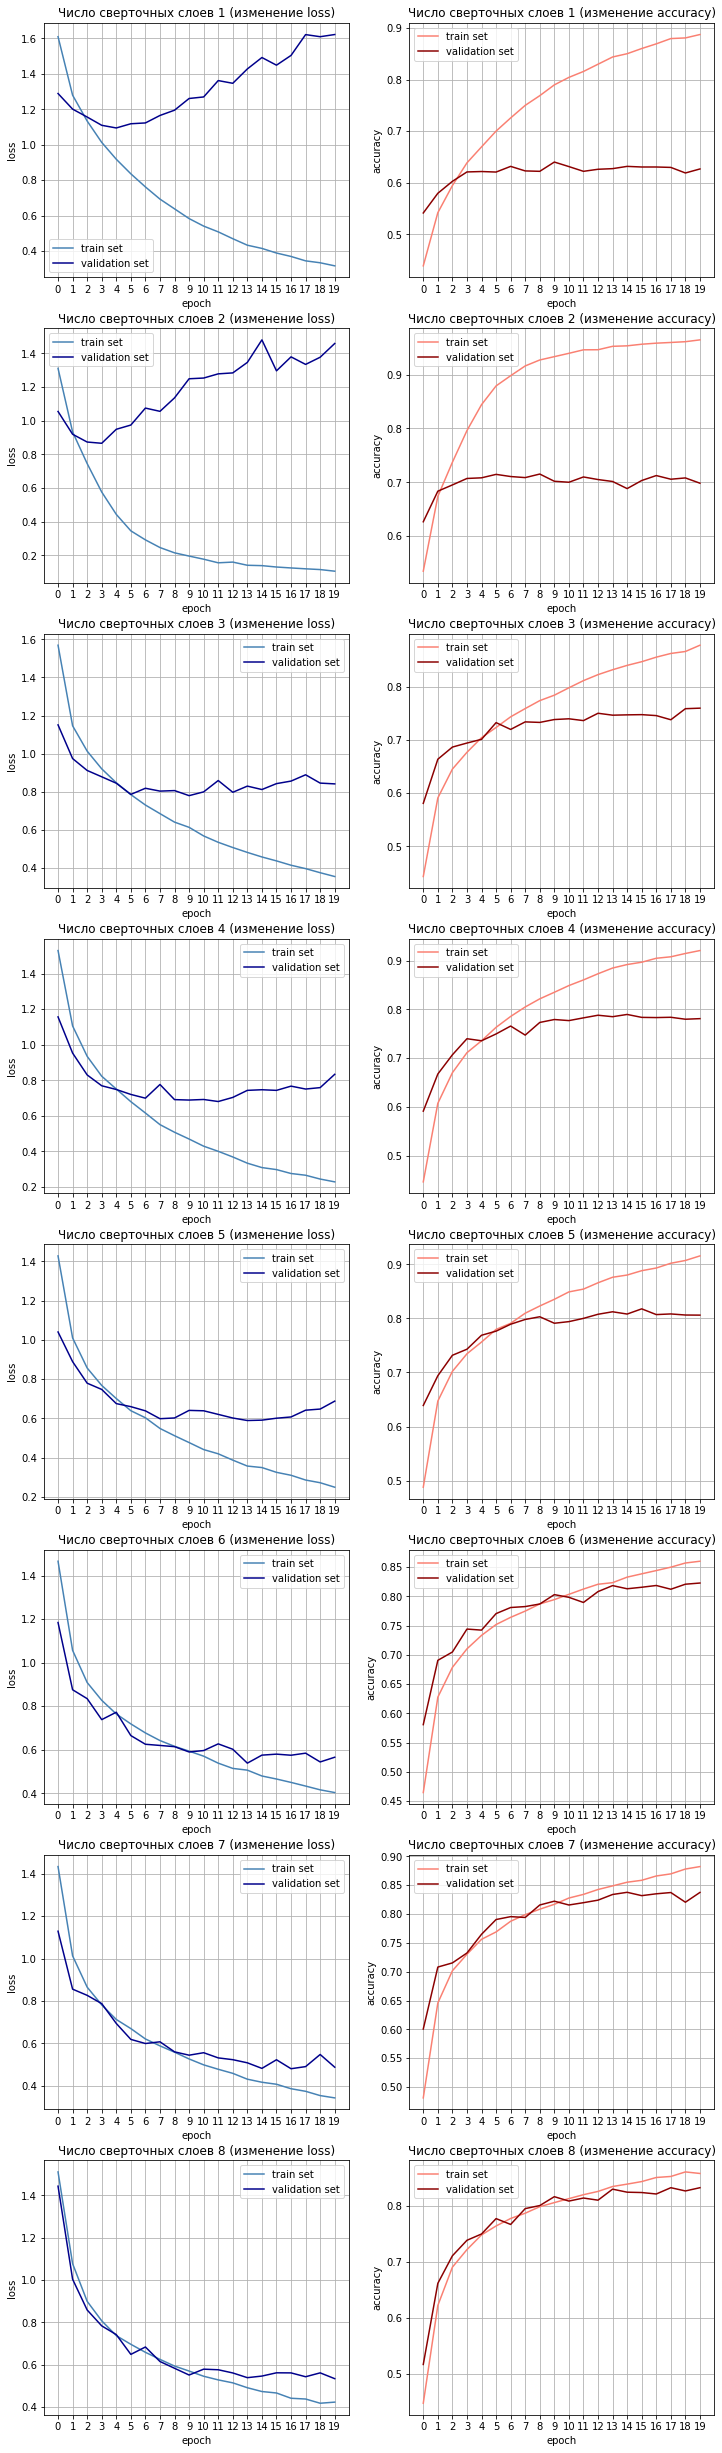

In [28]:
max_depths = tuple(range(1, 9))

_, axes = plt.subplots(
    len(max_depths), 
    2,
    figsize=(12, 5.5 * len(max_depths))
)
axes = axes.flatten()

with tqdm(total=len(max_depths), desc="Fitting", file=sys.stdout) as pbar:
    for i, max_depth in enumerate(max_depths):
        net, history = Cifar10Net.make_and_fit(
            make_cifar10_architector(max_depth),
            x_train,
            y_train,
            x_val,
            y_val,
            batch_size=128
        )

        plot_history(
            history,
            title=f"Число сверточных слоев {max_depth}",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-max-depth-{max_depth}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Число сверточных слоев",
            str(max_depth),
            history,
            score
        )

        pbar.update()

    pbar.set_description("Done")

plt.show();

## Исследование влияния количества нейронов

Для начала произведем исследование в том случае, когда во всех сверточных слоях одинаковое количество нейронов.

In [29]:
neurons_numbers = tuple(0x2 << i for i in range(7))
print(neurons_numbers)

(2, 4, 8, 16, 32, 64, 128)


In [31]:
def make_plain_architector(
    max_depth: int,
    value: int
) -> Callable[[], Generator[int, None, None]]:
    def generate():
        for depth in range(max_depth):
            yield value
            
    return generate

Done: 100%|██████████| 7/7 [15:46<00:00, 135.16s/it]


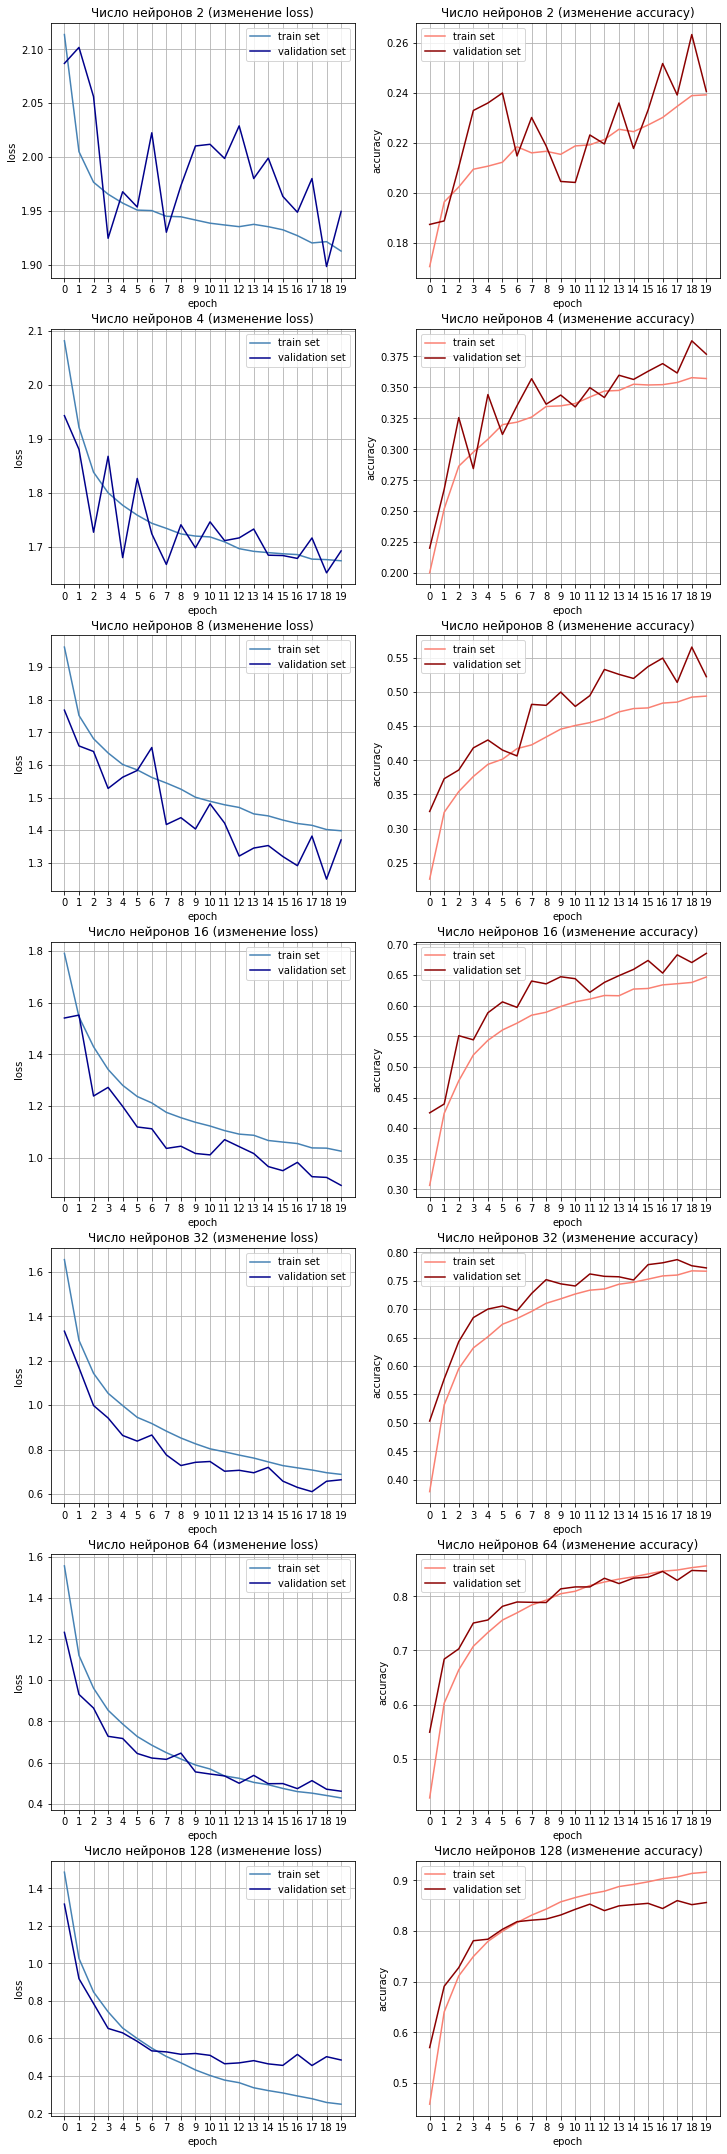

In [32]:
_, axes = plt.subplots(
    len(neurons_numbers), 
    2,
    figsize=(12, 5.5 * len(neurons_numbers))
)
axes = axes.flatten()

with tqdm(total=len(neurons_numbers), desc="Fitting", file=sys.stdout) as pbar:
    for i, neurons_number in enumerate(neurons_numbers):
        net, history = Cifar10Net.make_and_fit(
            make_plain_architector(9, neurons_number),
            x_train,
            y_train,
            x_val,
            y_val,
            batch_size=128
        )

        plot_history(
            history,
            f"Число нейронов {neurons_number}",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-neurons-{neurons_number}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Число нейронов",
            str(neurons_number),
            history,
            score
        )

        pbar.update()

    pbar.set_description("Done")

plt.show();

## Исследование влияния наличия слоев `MaxPooling2D`

Создать и обучить модель нейронной сети без `MaxPooling2D` слоев.

In [40]:
net, history = Cifar10Net.make_and_fit(
    make_cifar10_architector(5),
    x_train,
    y_train,
    x_val,
    y_val,
    use_pooling=False,
    batch_size=128,
    verbose=1
)



Iteration #1

Epoch 1/20
1407/1407 [==============================] - 31s 22ms/step - loss: 2.5303 - accuracy: 0.1516 - val_loss: 1.9839 - val_accuracy: 0.1990
Epoch 2/20
1407/1407 [==============================] - 30s 22ms/step - loss: 2.0350 - accuracy: 0.1882 - val_loss: 1.8214 - val_accuracy: 0.2524
Epoch 3/20
1407/1407 [==============================] - 31s 22ms/step - loss: 1.8582 - accuracy: 0.2629 - val_loss: 1.6607 - val_accuracy: 0.3704
Epoch 4/20
1407/1407 [==============================] - 31s 22ms/step - loss: 1.5509 - accuracy: 0.4116 - val_loss: 1.3188 - val_accuracy: 0.5304
Epoch 5/20
1407/1407 [==============================] - 31s 22ms/step - loss: 1.2924 - accuracy: 0.5260 - val_loss: 1.1952 - val_accuracy: 0.5724
Epoch 6/20
1407/1407 [==============================] - 30s 21ms/step - loss: 1.1444 - accuracy: 0.5887 - val_loss: 1.0371 - val_accuracy: 0.6396
Epoch 7/20
1407/1407 [==============================] - 30s 21ms/step - loss: 1.0246 - accuracy: 0.6328 - va

Отобразить информацию о созданной нейронной сети.

In [41]:
print(net.summary())

Model: "cifar10_net_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_65 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_82 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 32, 32, 64)     

Отобразить прогресс обучения нейронной сети.

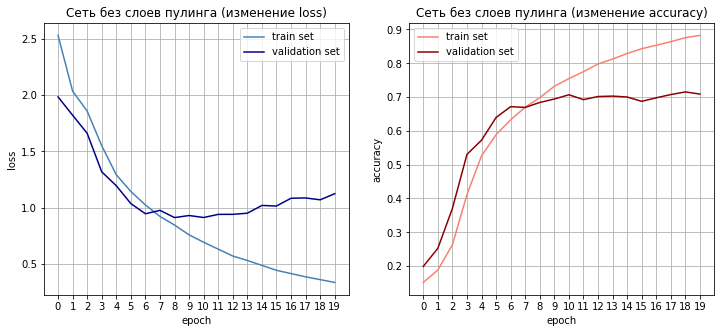

In [43]:
plot_history(history, "Сеть без слоев пулинга");

Сохранить архитектуру нейронной сети.

In [44]:
net.save(path / 'aiu-03-cifar-10-pro-model-max_depth-5-without-pooling')

Получить значения loss и accuracy для тестовой выборки.

In [45]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 1.07417
Test accuracy: 0.71540


Записать результаты в отчет.

In [46]:
update_report(report, "Слои пулинга", "Отсутствуют", history, score)

Создать и обучить модель нейронной сети со слоями `MaxPooling2D`.

In [47]:
net, history = Cifar10Net.make_and_fit(
    make_cifar10_architector(5),
    x_train,
    y_train,
    x_val,
    y_val,
    use_pooling=True,
    batch_size=128,
    verbose=1
)



Iteration #1

Epoch 1/20
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4352 - accuracy: 0.4912 - val_loss: 1.0512 - val_accuracy: 0.6332
Epoch 2/20
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0194 - accuracy: 0.6455 - val_loss: 0.9452 - val_accuracy: 0.6820
Epoch 3/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8818 - accuracy: 0.6958 - val_loss: 0.8235 - val_accuracy: 0.7206
Epoch 4/20
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7925 - accuracy: 0.7240 - val_loss: 0.7593 - val_accuracy: 0.7478
Epoch 5/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7243 - accuracy: 0.7492 - val_loss: 0.6997 - val_accuracy: 0.7562
Epoch 6/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6742 - accuracy: 0.7666 - val_loss: 0.6648 - val_accuracy: 0.7760
Epoch 7/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6323 - accuracy: 0.7828 - val_loss: 0.6701

Отобразить информацию о созданной нейронной сети.

In [48]:
print(net.summary())

Model: "cifar10_net_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_68 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 16, 16, 64)     

Отобразить прогресс обучения нейронной сети.

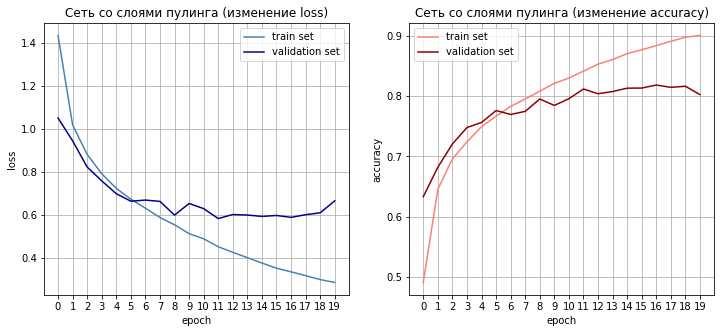

In [49]:
plot_history(history, "Сеть со слоями пулинга")

Сохранить архитектуру нейронной сети.

In [50]:
net.save(path / 'aiu-03-cifar-10-pro-model-max_depth-5-with-pooling')

Получить значения loss и accuracy для тестовой выборки.

In [51]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.65116
Test accuracy: 0.81080


Записать результаты в отчет.

In [52]:
update_report(report, "Слои пулинга", "Присутствуют", history, score)

## Исследование влияния `Dropout`

Создать и обучить нейронную сеть без слоев `Dropout`.

In [53]:
net, history = Cifar10Net.make_and_fit(
    make_cifar10_architector(9),
    x_train,
    y_train,
    x_val,
    y_val,
    dropout_rate=0.,
    batch_size=128,
    verbose=1
)



Iteration #1

Epoch 1/20
1407/1407 [==============================] - 11s 8ms/step - loss: 1.2909 - accuracy: 0.5362 - val_loss: 1.0947 - val_accuracy: 0.6192
Epoch 2/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.8249 - accuracy: 0.7166 - val_loss: 0.9668 - val_accuracy: 0.6892
Epoch 3/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.6493 - accuracy: 0.7772 - val_loss: 0.8672 - val_accuracy: 0.7198
Epoch 4/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.5259 - accuracy: 0.8192 - val_loss: 0.7163 - val_accuracy: 0.7708
Epoch 5/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.4287 - accuracy: 0.8538 - val_loss: 0.6542 - val_accuracy: 0.7862
Epoch 6/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.3417 - accuracy: 0.8830 - val_loss: 0.6377 - val_accuracy: 0.7976
Epoch 7/20
1407/1407 [==============================] - 11s 8ms/step - loss: 0.2745 - accuracy: 0.9043 - val_loss:

Отобразить информацию о созданной нейронной сети.

In [54]:
print(net.summary())

Model: "cifar10_net_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_71 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 16, 16, 64)     

Отобразить прогресс обучения нейронной сети.

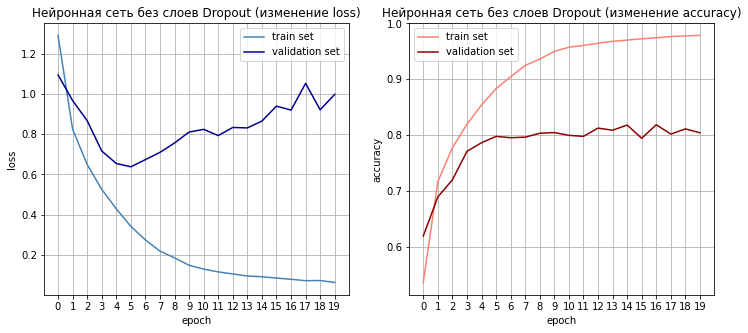

In [55]:
plot_history(history, "Нейронная сеть без слоев Dropout")

Сохранить архитектуру нейронной сети.

In [56]:
net.save(path / 'aiu-03-cifar-10-pro-model-dropout-rate-0')

Получить значения loss и accuracy для тестовой выборки.

In [57]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 1.04485
Test accuracy: 0.80850


Записать результаты в отчет.

In [58]:
update_report(report, "Величина dropout_rate", "0", history, score)

Исследование влияния величины `dropout_rate` на качество обучения нейронной сети.

In [59]:
dropout_rates = np.linspace(0.1, 0.7, num=7)
print(dropout_rates)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7]


Done: 100%|██████████| 7/7 [20:09<00:00, 172.81s/it]


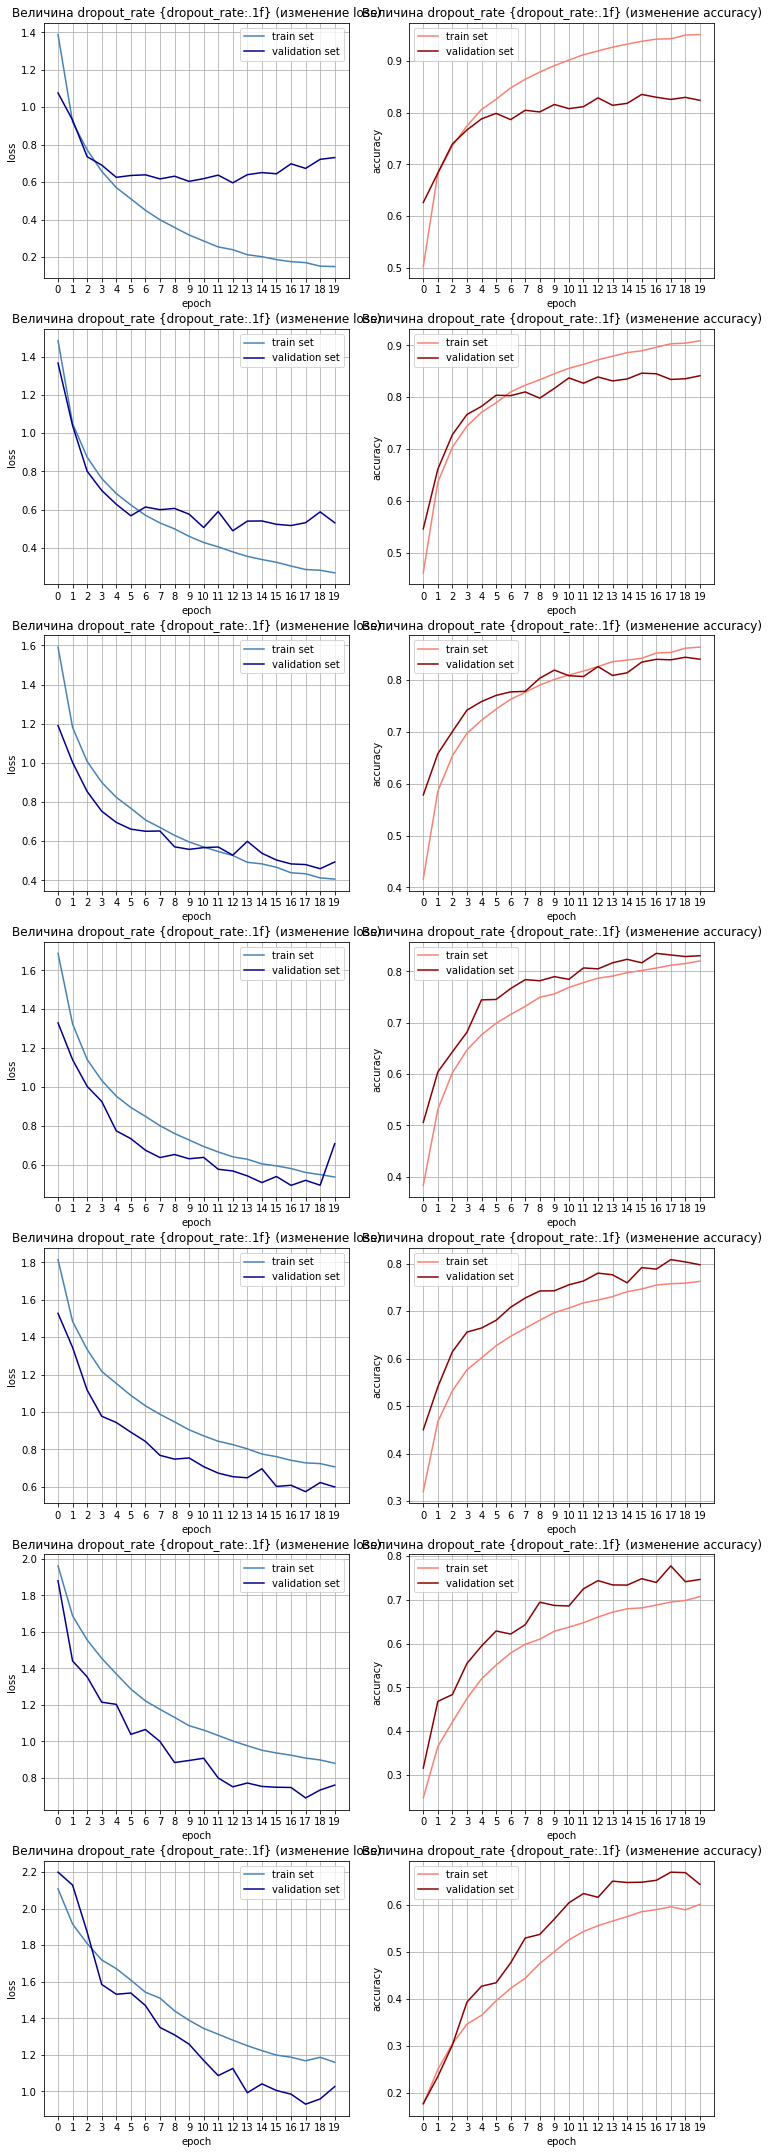

In [60]:
_, axes = plt.subplots(
    len(dropout_rates), 
    2,
    figsize=(12, 5.5 * len(dropout_rates))
)
axes = axes.flatten()

with tqdm(total=len(dropout_rates), desc="Fitting", file=sys.stdout) as pbar:
    for i, dropout_rate in enumerate(dropout_rates):
        net, history = Cifar10Net.make_and_fit(
            make_cifar10_architector(9),
            x_train,
            y_train,
            x_val,
            y_val,
            dropout_rate=dropout_rate,
            batch_size=128
        )

        plot_history(
            history, 
            "Величина dropout_rate {dropout_rate:.1f}",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-dropout-rate-{dropout_rate:.1f}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Величина dropout_rate",
            f"{dropout_rate:.1f}",
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

## Выводы

Отобразить сводную таблицу:

In [61]:
report

train validation    test
Категория              Значение                                 
Эталонная модель       9             0.884378      0.844  0.8428
Число сверточных слоев 1             0.887578     0.6268  0.6222
                       2             0.964511     0.6984  0.7009
                       3             0.878156     0.7598  0.7518
                       4             0.920911     0.7812  0.7762
                       5             0.915489      0.806  0.8065
                       6             0.859822     0.8226  0.8248
                       7               0.8822     0.8374  0.8377
                       8             0.857111     0.8318  0.8346
Число нейронов         2             0.239267     0.2406  0.2373
                       4             0.357133     0.3768   0.383
                       8             0.494111     0.5226  0.5186
                       16            0.646822     0.6854  0.6894
                       32            0.766844     0.7726  0.7758
                       64            0.855978     0.8466   0.843
                       128           0.916111     0.8562   0.859
Слои пулинга           Отсутствуют   0.882533     0.7088  0.7154
                       Присутствуют  0.900511     0.8024  0.8108
Величина dropout_rate  0             0.978333      0.804  0.8085
                       0.1           0.950778     0.8236  0.8281
                       0.2           0.908556     0.8412  0.8367
                       0.3           0.863578     0.8402  0.8428
                       0.4           0.820422     0.8306  0.8322
                       0.5           0.762911     0.7978  0.7996
                       0.6           0.707133      0.746  0.7393
                       0.7           0.601533     0.6442  0.6271

### Исследование влияния количества слоев `Conv2D`

Получить данные для эталонной модели.

In [63]:
query_rm = report.xs("Эталонная модель", level="Категория", axis=0, drop_level=True)

In [64]:
query_rm

,train,validation,test
Значение,,,
9,0.884378,0.844,0.8428


Получить данные для различного количества сверточных слоев.

In [66]:
query = report.xs("Число сверточных слоев", level="Категория", axis=0, drop_level=True)

In [67]:
query

,train,validation,test
Значение,,,
1,0.887578,0.6268,0.6222
2,0.964511,0.6984,0.7009
3,0.878156,0.7598,0.7518
4,0.920911,0.7812,0.7762
5,0.915489,0.806,0.8065
6,0.859822,0.8226,0.8248
7,0.8822,0.8374,0.8377
8,0.857111,0.8318,0.8346


Объединить полученные данные с данными эталонной модели.

In [68]:
query = pd.concat([query, query_rm])

In [69]:
query

,train,validation,test
Значение,,,
1,0.887578,0.6268,0.6222
2,0.964511,0.6984,0.7009
3,0.878156,0.7598,0.7518
4,0.920911,0.7812,0.7762
5,0.915489,0.806,0.8065
6,0.859822,0.8226,0.8248
7,0.8822,0.8374,0.8377
8,0.857111,0.8318,0.8346
9,0.884378,0.844,0.8428


Отобразить столбчатую диаграмму значений accuracy.

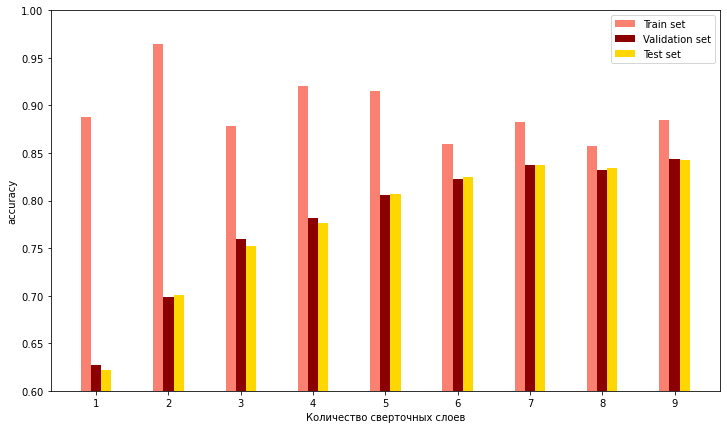

In [72]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.6, 1))
ax.set_xlabel("Количество сверточных слоев")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

Таким образом, при увеличении количества сверточных слоев величины accuracy для проверочной и тестовой выборок возрастают. Однако, если количество сверточных слоев больше 6, то рост значения accuracy для проверочной и тестовой выборок начинает замедляться.

### Исследование влияния количества нейронов в сверточных слоях

Получить данные для различного количества нейронов в сверточных слоях. При этом число нейронов постоянно для всех слоев `Conv2D`.

In [75]:
query = report.xs("Число нейронов", level="Категория", axis=0, drop_level=True)

In [76]:
query

,train,validation,test
Значение,,,
2,0.239267,0.2406,0.2373
4,0.357133,0.3768,0.383
8,0.494111,0.5226,0.5186
16,0.646822,0.6854,0.6894
32,0.766844,0.7726,0.7758
64,0.855978,0.8466,0.843
128,0.916111,0.8562,0.859


Отобразить столбчатую диаграмму значений accuracy.

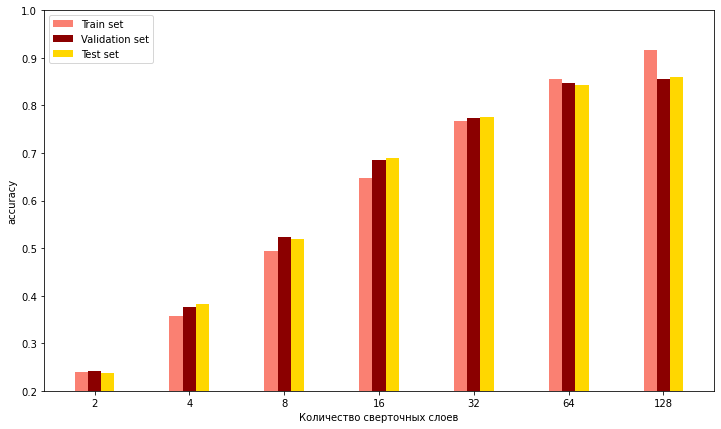

In [79]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.2, 1))
ax.set_xlabel("Количество нейронов в сверточных слоях")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show()

Очевидно, что с увеличением числа нейроной величины accuracy для проверочной и тестовой выборок возрастают. Для случая 128 нейронов во всех сверточных слоях результат сопоставим с результатом, полученным для эталонной модели, однако судя по графикам обучения такой нейронной сети можно сделать вывод, что она склонна к переобучению.

### Исследование влияния слоев `MaxPooling2D` в сети

Получить данные для сетей с использованием и без использования слоев с пулингом.

In [81]:
query = report.xs("Слои пулинга", level="Категория", axis=0, drop_level=True)

In [82]:
query

,train,validation,test
Значение,,,
Отсутствуют,0.882533,0.7088,0.7154
Присутствуют,0.900511,0.8024,0.8108


Отобразить столбчатую диаграмму значений accuracy.

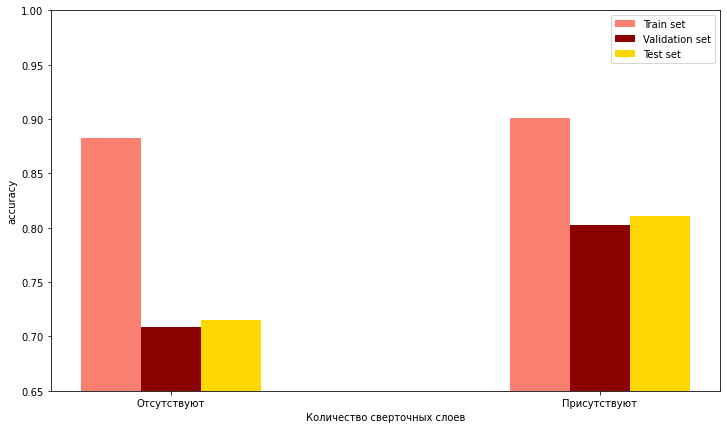

In [84]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.65, 1))
ax.set_xlabel("Наличие слоев пулинга")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

Нейронная сеть без использования слоев пулинга содержит значительно большее число обучаемых параметров по сравнению с нейронной сетью, использующей слои пулинга, и как результат, обучение такой сети проходит значительно медленнее. Отсутсвие слоев пулинга приводит к тому, что нейронная сеть теряет способность обобщать информацию, полученную с предыдущего сверточного слоя, этим и объясняется тот факт, что величины accuracy для проверочной и тестовой выборок меньше соответсующих величин accuracy для нейронной сети, использующей слои пулинга.

### Исследование влияния `Dropout`

Получить данные для сетей с использующих различные значения `dropout_rate`.

In [85]:
query = report.xs("Величина dropout_rate", level="Категория", axis=0, drop_level=True)

In [86]:
query

,train,validation,test
Значение,,,
0,0.978333,0.804,0.8085
0.1,0.950778,0.8236,0.8281
0.2,0.908556,0.8412,0.8367
0.3,0.863578,0.8402,0.8428
0.4,0.820422,0.8306,0.8322
0.5,0.762911,0.7978,0.7996
0.6,0.707133,0.746,0.7393
0.7,0.601533,0.6442,0.6271


Отобразить столбчатую диаграмму значений accuracy.

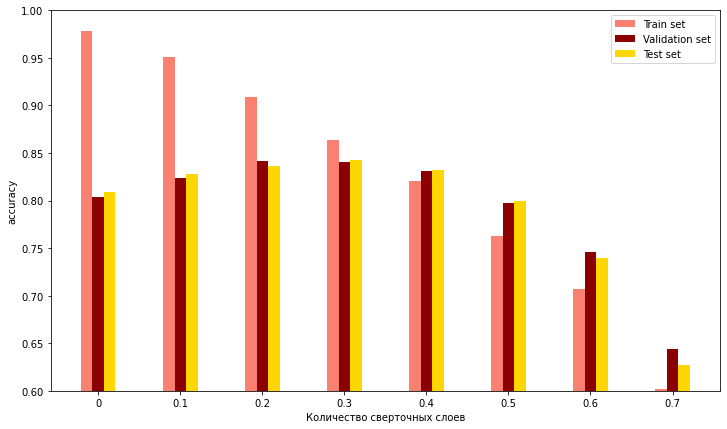

In [87]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.6, 1))
ax.set_xlabel("Величина dropout_rate")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

В случае, если в сети не были использованы слои `Dropout` (в данном случае `dropout_rate` равен 0), то в рузультате была получена большая разница между величинами accuracy для обучающей и проверочной выборок. Это говорит о том, что нейронная сеть переобучена. С ростом значения `dropout_rate` величины accuracy для проверочной и тестовой выборок сначала возрастают до значения `dropout_rate` примерно равного 0,3, после чего с ростом `dropout_rate` начинается снижение соответствующих значений accuracy. Кроме того с ростом значения `dropout_rate` снижается и абсолютная величина разности между значениями accuracy для обучающей и проверочной выборок. Наименьшего значения данная разность достигает при `dropout_rate` примерно равном 0,4. После чего снова начинается ее рост. Таким образом, оптимальное значение `dropout_rate` лежит в интервале от 0,2 до 0,4.